In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2245],
         [ 0.9177]]),
 tensor([[ 1.0000e+00, -2.2449e-01,  2.5198e-02, -1.8856e-03,  1.0583e-04,
          -4.7515e-06,  1.7778e-07, -5.7014e-09,  1.5999e-10, -3.9907e-12,
           8.9589e-14, -1.8284e-15,  3.4204e-17, -5.9067e-19,  9.4714e-21,
          -1.4175e-22,  1.9889e-24, -2.6264e-26,  3.2756e-28, -3.8702e-30],
         [ 1.0000e+00,  9.1772e-01,  4.2111e-01,  1.2882e-01,  2.9555e-02,
           5.4246e-03,  8.2972e-04,  1.0878e-04,  1.2479e-05,  1.2724e-06,
           1.1677e-07,  9.7422e-09,  7.4505e-10,  5.2596e-11,  3.4478e-12,
           2.1094e-13,  1.2099e-14,  6.5314e-16,  3.3300e-17,  1.6084e-18]]),
 tensor([4.5527, 5.3224]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0099406  1.2050054 -3.410238   5.570109 ]]


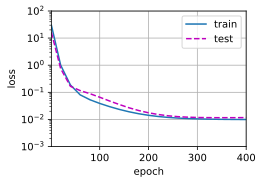

In [8]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.0411515 5.1232   ]]


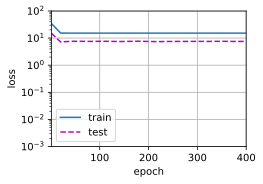

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9811244   1.3117881  -3.2851856   5.0686097  -0.4351788   0.843883
   0.06207511 -0.0871549  -0.07951381 -0.2231816   0.11856043  0.12091254
  -0.16086406 -0.19013749 -0.01435428  0.00846316  0.19784242  0.21929286
   0.11275229  0.01870473]]


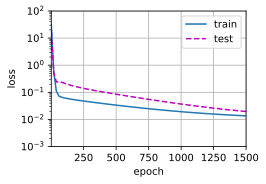

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)